## Reading all masks from the folders and producing one single mask file

In [1]:
import cv2
import glob
import numpy as np
DATA_DIR = "./input"
split = 'names'

from __future__ import print_function, division
import os
import pandas as pd
import skimage
import random
import skimage.io
from skimage import transform
from skimage.viewer import ImageViewer
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import glob


def read_from_file(list_file, comment='#'):
    with open(list_file) as f:
        lines  = f.readlines()
    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    return strings
        
def combining_masks():
    ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
    num_ids = len(ids)
    for i in range(num_ids):
        id = ids[i]
        image_files = glob.glob(DATA_DIR + '/' + id + '/images/*.png')
        image_file=image_files[0]
        image = cv2.imread(image_file,cv2.IMREAD_COLOR)
        H,W,C = image.shape
        one_mask = np.zeros((H,W), dtype=bool)
        mask_files =glob.glob(DATA_DIR + '/' + id + '/masks/*.png')
        for mask_file in mask_files:
            mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
            one_mask = one_mask |(mask>128)
        one_mask = (one_mask*255).astype(np.uint8)
        cv2.imwrite(DATA_DIR + '/' + id + '/mask.png', one_mask)


/anaconda/envs/py35/lib/python3.5/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [2]:
combining_masks()

## All random data augmentations in one function

In [6]:
def data_aug(image,label,angel=5,resize_rate=0.3, output_size=256):

    flip = random.randint(0, 1)
    size = image.shape[0]
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    sigma = random.uniform(0,0.6)
    scaling = random.uniform(0.1,1)
    
    # Rescale
    transform.rescale(image, scaling, mode='reflect')
    transform.rescale(label, scaling, mode='reflect')   
        
    # Create affine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    
    # Apply transform to image data
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
        
    #Shuffle the RGB channels to get color invariance
    p = [0,1,2]
    random.shuffle(p)
    image[:,:,:] = image[:,:,p]    
    #Change exposure/intensity randomly:
    imageAlp = image[:,:,2]  
    imageRest = image[:,:,0:3]
    if random.randint(0,1)==0:
        #use clahe
        image = exposure.equalize_adapthist(image)    
    if random.randint(0,1)==0:
        image = exposure.rescale_intensity(image,(0,random.uniform(0.5,1)))        
    
    #Rotate the image
    rotate = random.randint(0,3)
    image = transform.rotate(image, rotate*np.pi/2, mode='reflect')
    label = transform.rotate(label, rotate*np.pi/2, mode='reflect')

    #Corrupt data a little
    if sigma > 0:
        image = np.minimum(np.maximum(0.0,image + np.random.normal(0, sigma, image.shape)/255.0),255.0)
    
    
    # Randomly cropping image frame
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    
    
    #Now we resize the image
    image = transform.resize(image, (output_size, output_size))
    label = transform.resize(label, (output_size, output_size))
    image = image.transpose(2, 1, 0)
    #label  = cv2.threshold(label, 128, 255, cv2.THRESH_BINARY)[1]
    label[label > 0.] = 1
    return image.astype(float), label.astype(float)


## Creating Dataset to use it in DataLoader

In [14]:
from torch.utils.data.dataset import Dataset

class ImageMaskDataset(Dataset):

    def __init__(self, split, mode='train', transform= None):
        super(ImageMaskDataset, self).__init__()
        self.split = split
        self.mode = mode
        self.transform = transform
        ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
        self.ids = ids

    def __getitem__(self, index):
        id   = self.ids[index]
        name = id.split('/')[-1]
        image_file = DATA_DIR + '/' + id + '/images/' + name +'.png'
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)

        if self.mode in ['train']:
            mask_file =  DATA_DIR + '/' + id + '/mask.png'
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            return self.transform(image,mask)

        if self.mode in ['test']:
            return self.transform(image)

    def __len__(self):
        return len(self.ids)

#### Function for image visualisation

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *
def image_show(name, image, resize=1):
    H,W = image.shape[0:2]
    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, image.astype(np.uint8))
    cv2.resizeWindow(name, round(resize*W), round(resize*H))

#### Simple data augmentation for testing

In [16]:
WIDTH = 256
HIGHT =256
def simple_augment(image,mask):
        image = cv2.resize(image,(WIDTH,HIGHT))
        image = image.transpose(2, 1, 0)
        mask  = cv2.resize(mask,(WIDTH,HIGHT))
        mask  = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]
        mask[mask == 255.] = 1
        return image.astype(float),mask.astype(float)

dataset = ImageMaskDataset(
        'names', mode='train', transform = data_aug
    )
sampler = RandomSampler(dataset)

In [17]:
dataset[1][0]

/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[0.03733078, 0.06868819, 0.12337991, ..., 0.01101218,
         0.01112727, 0.0137063 ],
        [0.06318242, 0.11783048, 0.18273718, ..., 0.01214146,
         0.0134692 , 0.01560212],
        [0.08741388, 0.16250577, 0.22535825, ..., 0.01446765,
         0.01432047, 0.01434213],
        ...,
        [0.02146393, 0.02205543, 0.02101131, ..., 0.01663252,
         0.01539006, 0.01468259],
        [0.02228943, 0.02180286, 0.02147239, ..., 0.01567436,
         0.01594786, 0.0159703 ],
        [0.02037065, 0.01839806, 0.01844856, ..., 0.01458358,
         0.01499923, 0.01579887]],

       [[0.03514952, 0.0708192 , 0.12248045, ..., 0.0107943 ,
         0.01248317, 0.01317274],
        [0.06037134, 0.11845544, 0.18345194, ..., 0.01172884,
         0.01434856, 0.01439285],
        [0.08558366, 0.16044039, 0.22479085, ..., 0.01423033,
         0.01452955, 0.01593639],
        ...,
        [0.02164608, 0.02215196, 0.02214578, ..., 0.01583521,
         0.01508147, 0.01458998],
        [0.0

## `UNet` class is based on https://arxiv.org/abs/1505.04597

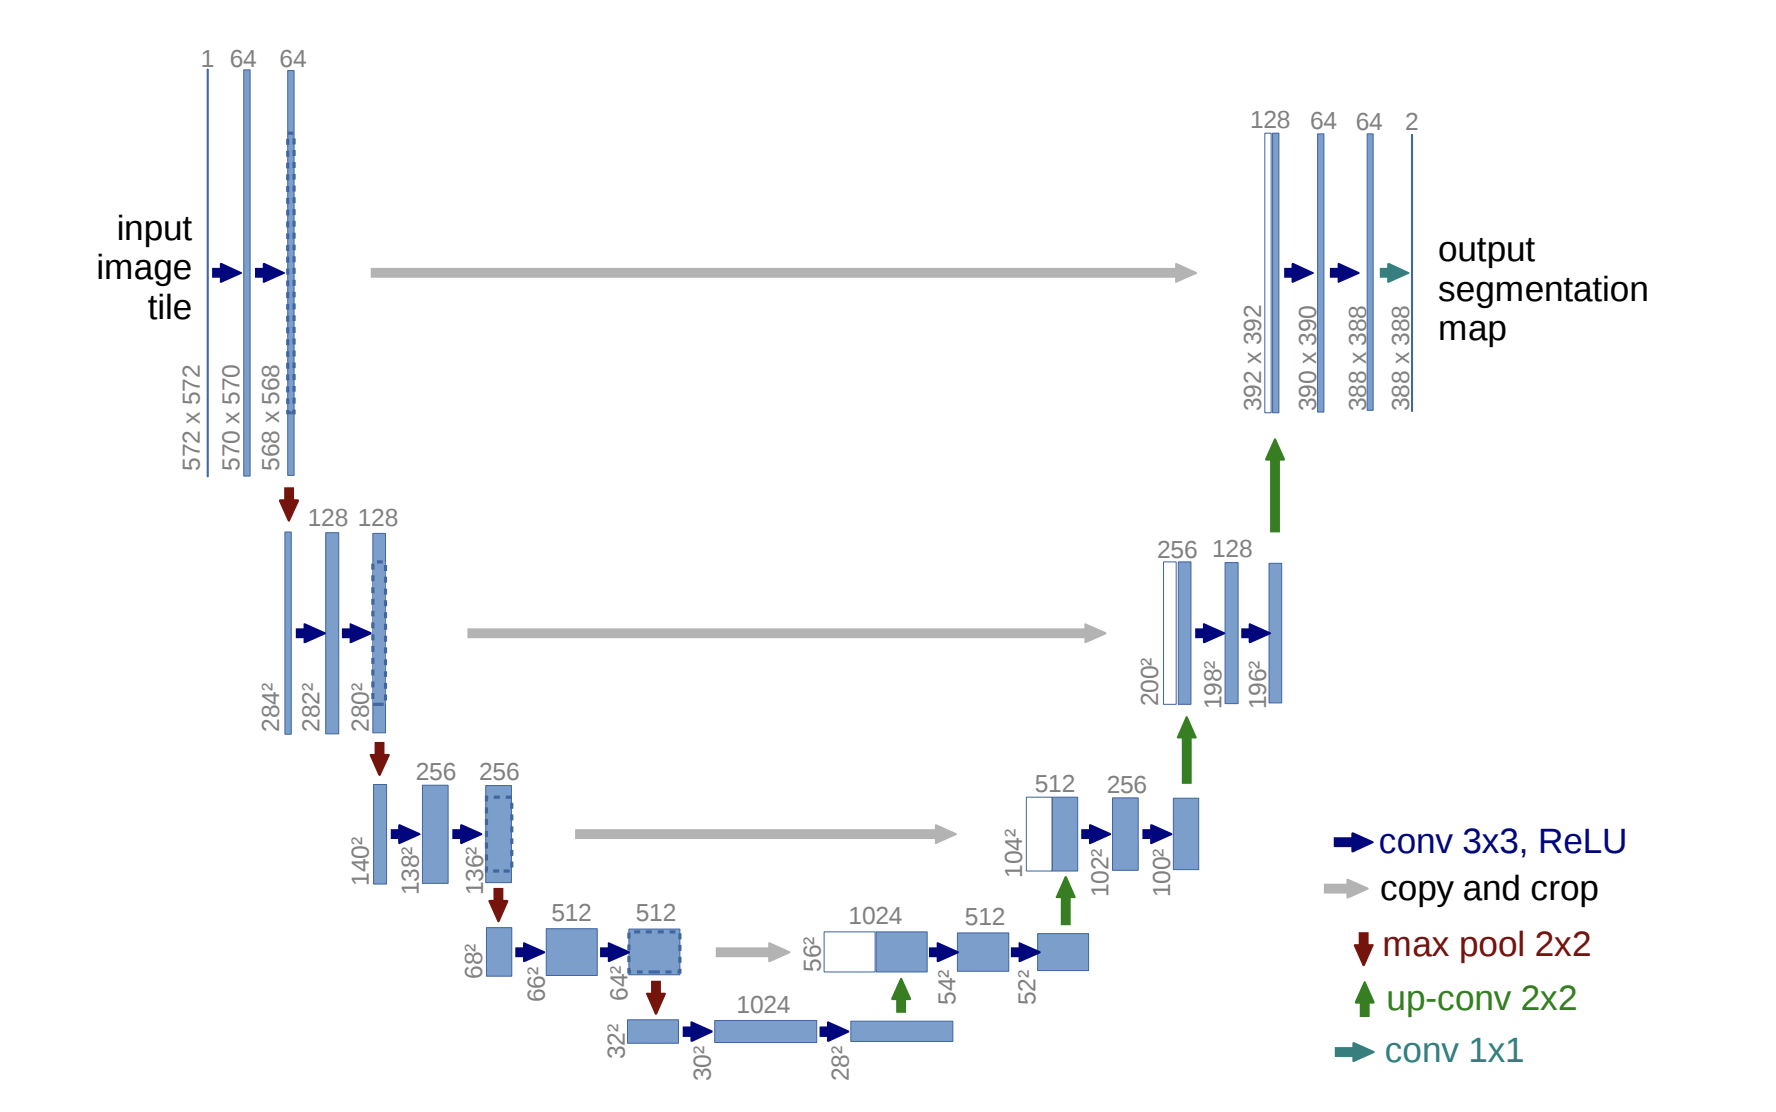

In [18]:
import torch.nn as nn
def UpDownConv(in_channels, mid_channels, out_channels):
    return nn.Sequential(
            *ConvRelu(in_channels, mid_channels, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(mid_channels, out_channels, kernel_size=3, stride=1, padding=1 ),
    )
def ConvRelu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
class UNet(nn.Module):
    
    def __init__(self, in_shape, num_classes):
        super(UNet, self).__init__()
        in_channels, height, width = in_shape

        self.down1 = nn.Sequential(
            *ConvRelu(in_channels, 16, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(16, 32, kernel_size=3, stride=2, padding=1 ),
        )
        #64
        self.down2 = UpDownConv(32, 64, 128)
        #32
        self.down3 = UpDownConv(128, 256, 512)
        #16
        self.down4 = UpDownConv(512, 512, 512)
        #8
        self.same = nn.Sequential(
            *ConvRelu(512,512, kernel_size=1, stride=1, padding=0 ),
        )
        #16
        self.up4 = UpDownConv(1024, 512, 512)
        #16
        self.up3 = UpDownConv(1024, 512, 128)
        #32
        self.up2 = UpDownConv(256, 128, 32)
        #64
        self.up1 = UpDownConv(64, 64, 32)
        #128

        self.up0 = nn.Sequential(
            *ConvRelu(32, 32, kernel_size=3, stride=1, padding=1 ),
        )
        #256

        self.classify = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

    def forward(self, x):

        down1 = self.down1(x)
        out   = F.max_pool2d(down1, kernel_size=2, stride=2) #64
        down2 = self.down2(out)
        out   = F.max_pool2d(down2, kernel_size=2, stride=2) #32
        down3 = self.down3(out)
        out   = F.max_pool2d(down3, kernel_size=2, stride=2) #16
        down4 = self.down4(out)
        out   = F.max_pool2d(down4, kernel_size=2, stride=2) # 8
        out   = self.same(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #16
        out   = torch.cat([down4, out],1)
        out   = self.up4(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #32
        out   = torch.cat([down3, out],1)
        out   = self.up3(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #64
        out   = torch.cat([down2, out],1)
        out   = self.up2(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #128
        out   = torch.cat([down1, out],1)
        out   = self.up1(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #256
        out   = self.up0(out)
        out   = self.classify(out)
        return out
    

In [19]:
num_classes = 1
batch_size  = 8
C = 3
from torch.autograd import Variable
import torch.nn.functional as F

inputs = torch.randn(batch_size,C,HIGHT,WIDTH)
labels = torch.LongTensor(batch_size,HIGHT,WIDTH).random_(1).type(torch.FloatTensor)

net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train().cuda()
x = Variable(inputs).cuda()
y = Variable(labels).cuda()
logits = net.forward(x)

probs = F.sigmoid(logits)
probs_flat = probs.view (-1)
targets_flat = y.view(-1)
loss = nn.BCELoss().cuda()
output = loss(probs_flat, targets_flat)
output.backward()

print(type(net))
print(net)

<class '__main__.UNet'>
UNet(
  (down1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(256, 512

In [20]:
output

Variable containing:
 0.7909
[torch.cuda.FloatTensor of size 1 (GPU 0)]

### Soft Dice Loss implementation:

In [33]:
class DiceLoss(nn.Module):
    def __init__(self): 
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))

### Training prodecure 

In [34]:
import torch.optim as optim
LR = 0.0002
batch_size = 16
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train()
epochs = 100
cuda = True
ADAM = True


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def train():
    if ADAM:
        optimizer = \
                    optim.Adam(net.parameters(),
                               lr= LR, betas=(0.5, 0.999))
    else:
        optimizer = \
                    optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                              lr=0.01/iter_accum, momentum=0.9, weight_decay=0.0001)
        
    train_dataset = ImageMaskDataset(
                                'names', mode='train',
                                transform = data_aug)
    train_loader  = DataLoader(
                        train_dataset,
                        sampler = RandomSampler(train_dataset),
                        batch_size  = batch_size,
                        drop_last   = True,
                        num_workers = 8)
    
    i = 0
    if cuda:
        net.cuda()
    while  i < epochs:  
        sum_train_loss = 0.0
        sum_train_acc  = 0.0
        sum = 0
        net.train()
        optimizer.zero_grad()
        for index, data  in enumerate(train_loader):
            image,mask = data
            if cuda:
                tensors = Variable(image).cuda()
                masks   = Variable(mask).cuda()
            else:
                tensors = Variable(image)
                masks   = Variable(mask)
            logits  = net(tensors.float())
            probs   = F.sigmoid(logits).view(-1)
            masks_flat = masks.view(-1)
            if cuda:
                loss = DiceLoss().cuda()
            else:
                loss = DiceLoss()
                
            output = loss(probs, masks_flat.float())
            output.backward()
            optimizer.step()
            optimizer.zero_grad()
            adjust_learning_rate(optimizer, i)
            batch_loss = output.data[0]
            sum_train_loss += batch_loss
            print('\r epoch: %f| LR: %f|batch_loss:  %f  sum_train_loss: %f' % \
                  (i, LR, batch_loss, sum_train_loss), end='',flush=True)
        i = i +1


In [35]:
import warnings
warnings.filterwarnings('ignore')
train()

 epoch: 99.000000| LR: 0.000200|batch_loss:  0.339873  sum_train_loss: 15.993557

In [36]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model.pth')